# Introducción

Empezaremos con la detección del tablero de ajedrez, junto con el aislamiento de cada casilla para su posterior identificación.
El método que hemos usado difiere bastante de nuestro trabajo anterior y el trabajo de investigación.

El trabajo anterior usaba el Algoritmo de Canny y la Transformada de Hough para obtener los bordes del tablero, luego, para obtener las esquinas del mismo, calculaban las intersecciones de las lineas verticales y horizontales obtenidas de aplicar Hough.

En un principio nosotros también usamos este método, pero decidimos cambiarlo al actual, la razón es que la Transformada de Hough, en un tablero de cuatro en rayas, devolvía una cantidad muy pequeña de líneas, en cambio, en nuestro tablero de ajedrez, la cantidad era enorme, por tanto, el procesado posterior para calcular las intersecciones iba a tardar demasiado tiempo.
Se podría haber implementado un método para ignorar las líneas interiores y solo dejar las más cercanas a los bordes de la imágen, pero igualmente pensamos que sería mejor buscar otro método.


Otro de los métodos que pensamos usar era el algoritmo de cáculo de esqunas "Harris corner detector" muy parecido al anterior y para evitar el procesamiento de calcular las intersecciones entra las líneas, decidimos abandonar este método también porque no nos arrojaba buenos resultados.

Por último se nos ocurrió obtener el contorno del tablero, para ello invertimos el color de la imágen (si la imágen no se invertía nos devolvía como contorno el borde de la imágen, ya que findContours detecta el contorno en pixeles con valor 1).
Una vez obtenido el contorno, de todos los puntos que lo forman, obtendremos aquellos que esten más cerca de las esquinas de la imágen, esto nos dará las 4 esquinas del tablero.

Una vez obtenidas las 4 esquinas, ya podremos hacer la transformación de perspectiva para centrar el tablero.

Posteriormente haremos un crop de los bordes exteriores para encajar el tablero y facilitar el aislamiento de las casillas.
Por último, sabiendo que un tablero de ajedrez tiene 8x8 casillas y todas del mismo tamaño, fácilmente podemos aislar cada casilla.

Destacar que el método usado arroja muy buenos resultados, incluso con imágenes con ángulos muy diferentes y tableros rotados.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

In [2]:
def muestra(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.xticks([]),plt.yticks([]) #Ocultar ejes
    plt.show()

In [3]:
clase = {0:"vacio",
          1:"Torre blanca",
          2:"Alfil blanco",
          3:"Caballo blanco",
          4:"Reina blanca",
          5:"Rey blanco",
          6:"Peon blanco",
          7:"Torre negra",
          8:"Alfil negro",
          9:"Caballo negro",
          10:"Reina negra",
          11:"Rey negro",
          12:"Peon negro"
         }

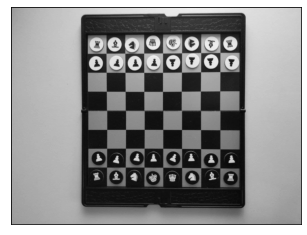

In [46]:
img = cv2.imread("imgs/tableros/04.jpg")
#img = cv2.imread("imgs/tableros/jaque_mate.jpg")

def preprocesarImagen(img):
    
    imgRes = cv2.GaussianBlur(img, (5,5), 0.6)
    imgRes = cv2.cvtColor(imgRes, cv2.COLOR_BGR2GRAY)
    
    return imgRes

img = preprocesarImagen(img)
muestra(img)

Aplicamos un threshold para binarizar la imágen.

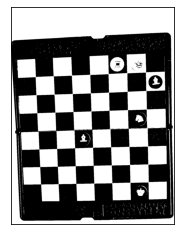

In [5]:
def aplicarThreshold(img):
    
    ret,thresh = cv2.threshold(img,85,255,cv2.THRESH_BINARY)
    
    return thresh

imgModificada = aplicarThreshold(img)
muestra(imgModificada)

A continuación, invertiremos los colores de la imágen para que la función findContours de OpenCV detecte el borde del tablero y no el borde de la imagen, ya que findCountours solo tiene en cuenta los pixeles con valor 1, si no invertimos los colores, el contorno que encontraria primero seria el del marco de la imágen.

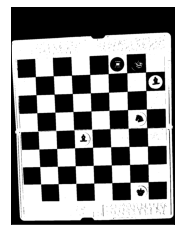

In [6]:
def invertirColores(img):
    img = 255-img
    return img
def obtenerContornos(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

imgModificada = invertirColores(imgModificada)
contornos = obtenerContornos(imgModificada)

muestra(imgModificada)

Hacemos una copia de la imágen para dibujar el contorno sobre ella, como el método findContours puede detectar varios contornos, nos vamos a quedar con el que tenga más puntos, ya que pasa que detecta contornos "incompletos"

Para que se vea claramente hemos puesto el contorno a gran tamaño.

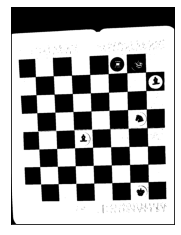

In [7]:
def dibujarContornos(img):
    copiaImg = img.copy()
    cv2.drawContours(copiaImg, contornos, -1, (255,0,0),100)
    return copiaImg

muestra(dibujarContornos(imgModificada))

def obtenerContornoValido(contornos):
    i = 0
    contornoFinal = contornos[0]
    for contorno in contornos:
        if len(contorno) > i:
            i = len(contorno)
            contornoFinal = contorno
    return contornoFinal
contornoValido = obtenerContornoValido(contornos)

Método para obtener las esquinas de un contorno, básicamente de todos los puntos de un contorno busca aquellos que esten más cerca a las esquinas, los 4 resultantes serán los puntos de cada esquina de nuestro tablero.

Primera versión del método, es mejorable.

In [8]:
def obtenerEsquinas(contorno):
    superiorIzq = (0,0)
    inferiorIzq = (0, img.shape[0])
    inferiorDrcha = (img.shape[1], img.shape[0])
    superiorDrcha = (img.shape[1], 0)
    listaEsquinas = [(0,0), (0,0), (0,0), (0,0)]
    superiorIzqActual = 9999
    inferiorIzqActual = 9999
    inferiorDrchaActual = 9999
    superiorDrchaActual = 9999
    for punto in contorno:
        punto = (punto[0][0], punto[0][1])
        distanciaSupIzq = distancia(punto, superiorIzq)
        distanciaInfIzq = distancia(punto, inferiorIzq)
        distanciaInfDrcha = distancia(punto, inferiorDrcha)
        distanciaSupDrcha = distancia(punto, superiorDrcha)
        if distanciaSupIzq < superiorIzqActual:
            listaEsquinas[0] = punto
            superiorIzqActual = distanciaSupIzq
        if distanciaInfIzq < inferiorIzqActual:
            listaEsquinas[1] = punto
            inferiorIzqActual = distanciaInfIzq          
        if distanciaInfDrcha < inferiorDrchaActual:
            listaEsquinas[2] = punto
            inferiorDrchaActual = distanciaInfDrcha
        if distanciaSupDrcha < superiorDrchaActual:
            listaEsquinas[3] = punto
            superiorDrchaActual = distanciaSupDrcha     
    return listaEsquinas

def distancia(p1, p2):
    x,y = p1
    x2,y2 = p2
    return math.sqrt(pow(x2-x, 2) + pow(y2-y,2))

Una vez obtenidos los 4 puntos de las esquinas podemos hacer una transformación de perspectiva.

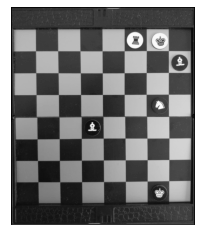

In [9]:
esquinas = obtenerEsquinas(contornoValido)

input =  np.float32([esquinas])
output = np.float32([[0,0],[0, int(distancia(esquinas[0], esquinas[1]))],[int(distancia(esquinas[1], esquinas[2])), int(distancia(esquinas[0], esquinas[1]))],[int(distancia(esquinas[1], esquinas[2])), 0]])
persp = cv2.getPerspectiveTransform(input, output)
dst = cv2.warpPerspective(img, persp, (int(distancia(esquinas[1], esquinas[2])),int(distancia(esquinas[0], esquinas[1]))), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
muestra(dst)

Hacemos un crop de la imágen para eliminar los bordes anchos de nuestro tablero y encajar bien la imagen.

Primera versión, me gustaría hacerlo más genérico.

In [10]:
def elimina_bordes(img):
    bordeSup = int(0.093 * img.shape[0])
    bordeLat = int(0.036 * img.shape[1])        
    return img[bordeSup:img.shape[0]-bordeSup, bordeLat:img.shape[1]-bordeLat] # tablero sin bordes

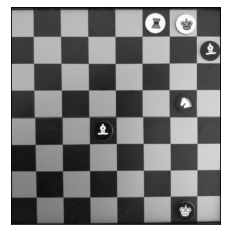

In [11]:
crop = elimina_bordes(dst)
muestra(crop)
#ELIMINANDO RUIDO CON OPENCV
#crop = cv2.fastNlMeansDenoising(crop, None, 6)


Obtenemos cada casilla del tablero 

In [12]:
def casillas(tablero):
    tami = int(tablero.shape[0]/8)
    tamj = int(tablero.shape[1]/8) 
    
    res =[[None for _ in range(8)] for _ in range(8)]
    for i in range(8):
        for j in range(8):
            h,w = tablero.shape
            casilla = tablero[tami * i:tami * (i+1), tamj * j: tamj * (j+1)]
            res[i][j] = casilla
            #muestra(casilla)
    return res

cas = casillas(crop)
#casillasFinal = cv2.Canny(cas, 100, 200,100)



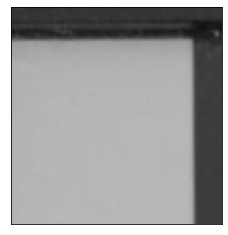

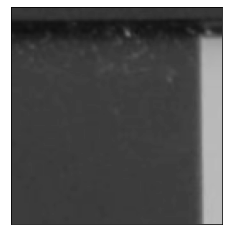

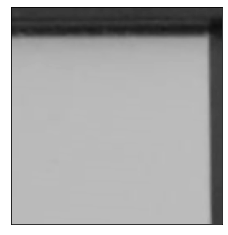

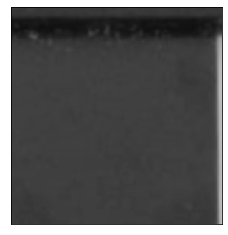

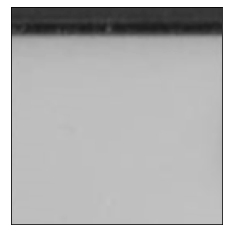

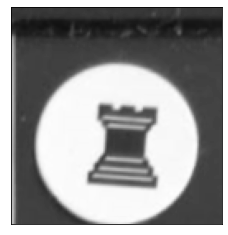

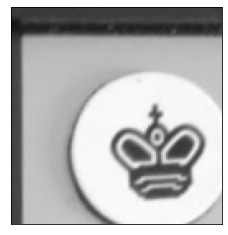

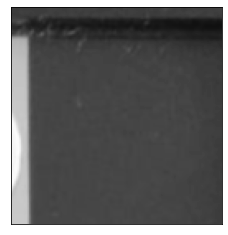

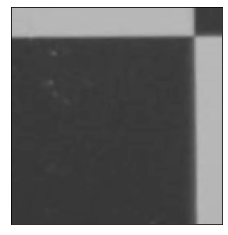

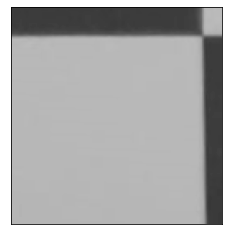

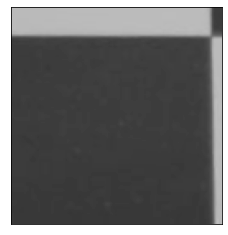

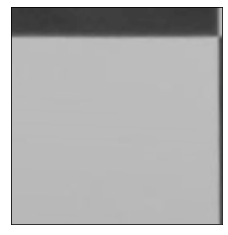

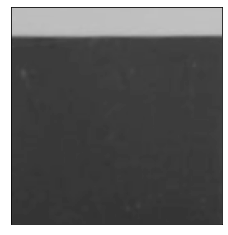

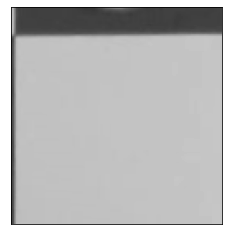

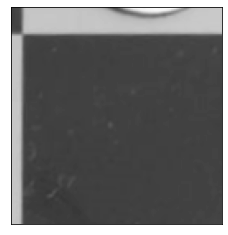

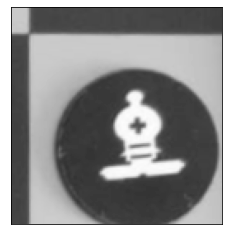

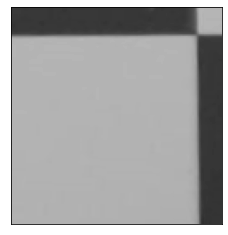

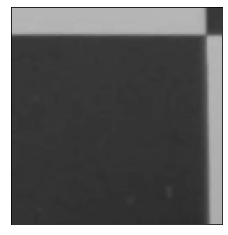

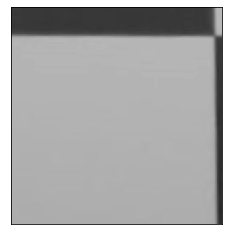

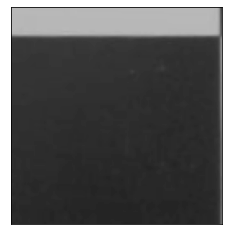

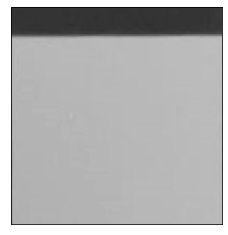

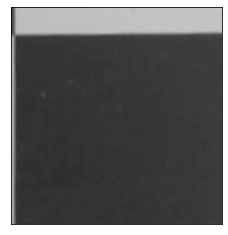

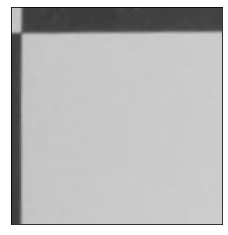

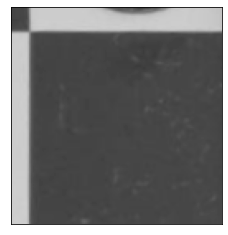

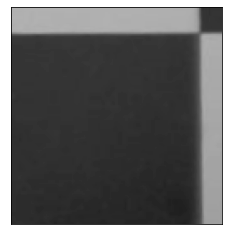

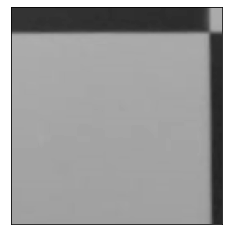

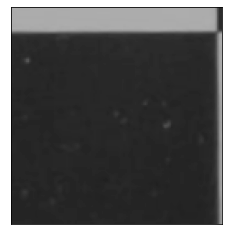

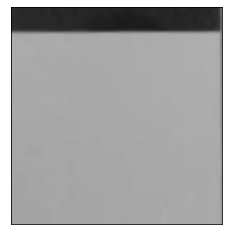

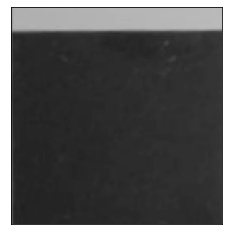

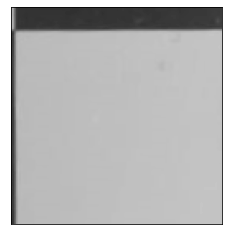

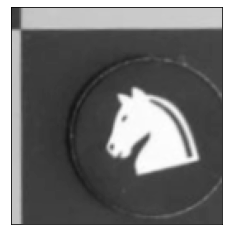

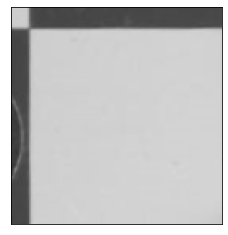

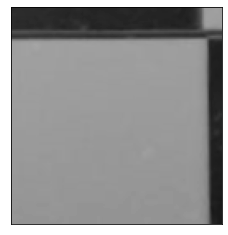

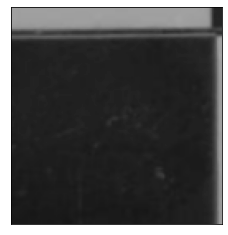

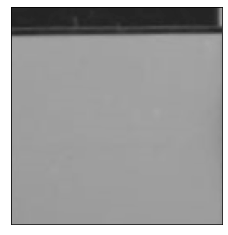

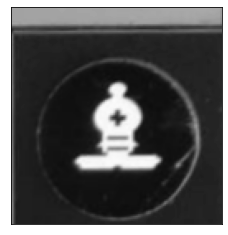

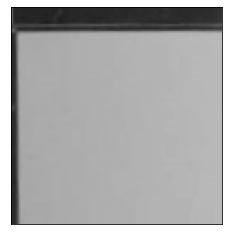

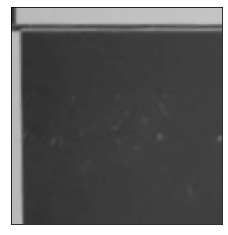

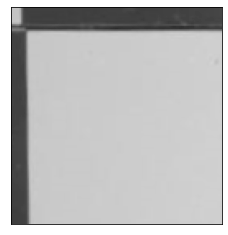

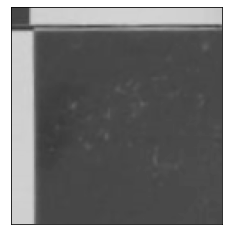

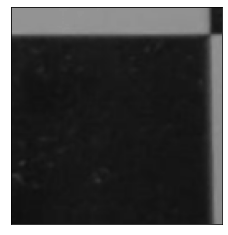

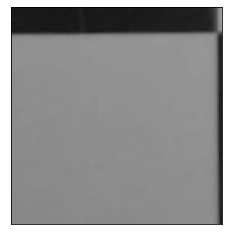

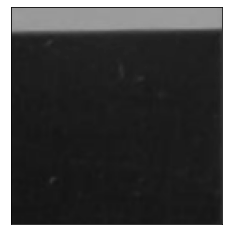

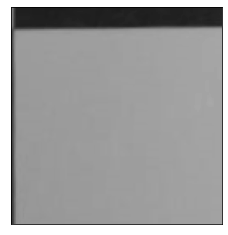

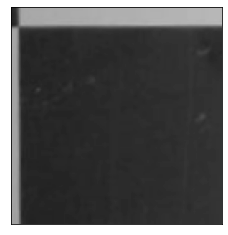

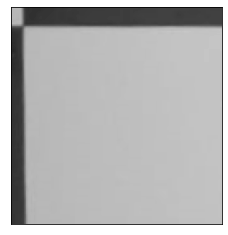

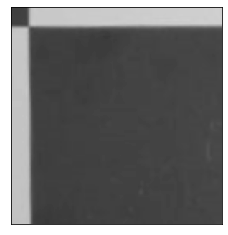

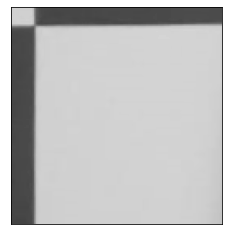

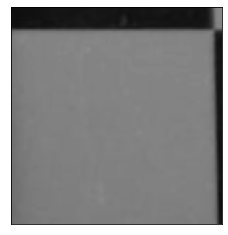

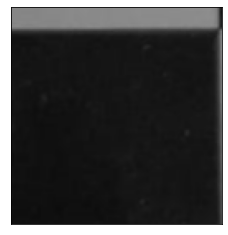

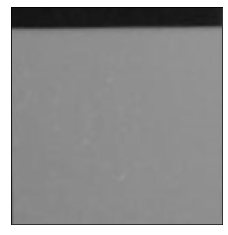

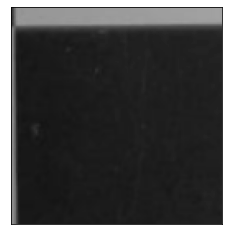

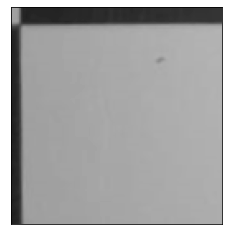

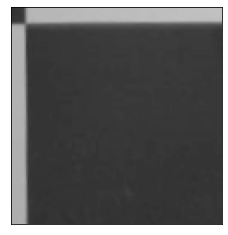

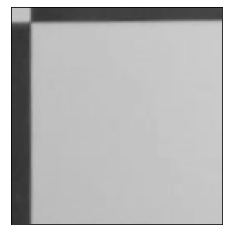

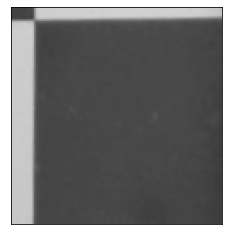

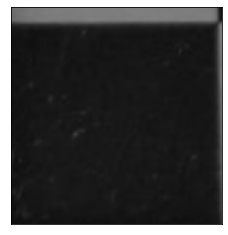

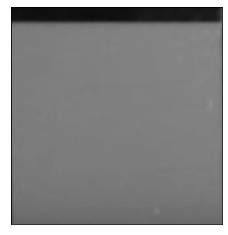

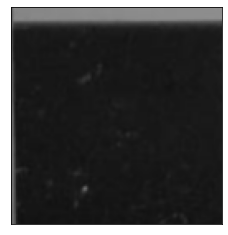

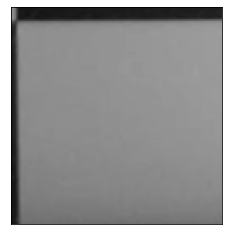

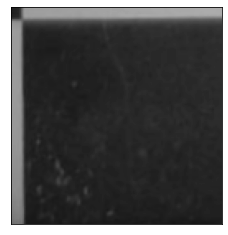

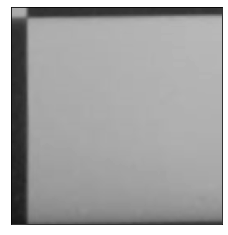

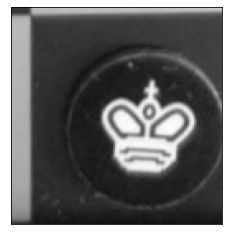

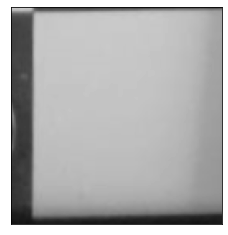

In [13]:
for i in range(8):
    for j in range(8):
        muestra(cas[i][j])

HASTA AQUÍ LA DETECCIÓN DEL TABLERO Y LAS CASILLAS, A CONTINUACIÓN PROCEDEMOS A LA DETECCIÓN DE LAS PIEZAS.

Para hacer el reconocimientos de piezas, lo primero será crear una lista que contengan todos los descriptores correspondientes a cada una de las clases (peón, alfil, torre...). Para ello, la función getDescriptors navega un directorio donde se encuentran las imagenes que definen cada clase, obtiene los keypoints de cada una, y acto seguido obtiene los descriptores.

In [14]:
def getDescriptors():
    orb = cv2.ORB_create(edgeThreshold=9)
    descriptors = []
    for i in range(1,13):
        img = cv2.imread("./imgs/clases/"+str(i)+".jpg",0) 
        _,d = orb.detectAndCompute(img, None)  
        descriptors.append(d)
    return descriptors

Una vez obtenidos los descriptores característicos de cada clase, es posible compararlos con el descriptor de una casilla en concreto utilizando la distancia hamming. Cuanto menor sea esa distancia, más probable es que la ficha pertenezca a una determinada clase. La ficha pertenecerá a la clase cuya distancia entre ambas sea menor.

Las comparaciones entre el descriptor de la clase y el de la ficha que queremos clasificar, se realizan con BFMatcher. Esta clase se encarga de aplicar la distancia hamming a ambos descriptores.

In [15]:
def identificaFigura(img, descriptors):
    orb = cv2.ORB_create(edgeThreshold=9)
    _, desO = orb.detectAndCompute(img, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    clase = 0
    best = 60
    for i,des in enumerate(descriptors, start=1):
        if type(des) is np.ndarray:
            matches = bf.match(desO,des)
            matches = sorted(matches, key = lambda x:x.distance)
            media = distanciaMedia(matches[:30])
            if media < best:
                    best = media
                    clase = i
    
    return clase

Un descriptor es una lista con cadenas de 1s y 0s, cada una representando la descripción de un keypoint. Para comparar dos imagenes, se utiliza la función (contenida en la clase BFMatcher) match(), la cuál devuelve la distancia hamming aplicada a cada una de esas cadenas, obteniendo así varias distancias. Con la función distanciaMedia() tomamos como parametro la lista de todas esas distancias para quedarnos solamente con una distancia media.

In [16]:
def distanciaMedia(matches):
    if len(matches)>10:
        return sum(map(lambda m: m.distance,matches)) / len(matches)
    else:
        return 9999999

Para finalizar el proceso de reconocimiento de fichas en un tablero, se unifican las anteriores funciones en una, creaTablero. Esta se encargará de, a partir de una matriz de imagenes de cada casilla, obtener una matriz con la que podremos operar a la hora de averiguar si existe jaque o no.

In [17]:
def creaTablero (casillas):
    descriptors = getDescriptors()
    res = np.zeros((8,8), dtype=np.uint8)
    for i in range(8):
        for j in range(8):
            res[i,j] = identificaFigura(casillas[i][j], descriptors)
    
    return res

In [18]:
tableroAProbar = creaTablero(cas)

In [19]:
print(tableroAProbar)

[[ 0  0  0  0  0  7 11  0]
 [ 0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0]
 [ 0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0]]


In [20]:
def comprobarTablero(tablero):
    
    tableroCorrecto = True
    
    listaPiezas = np.array([])
    
    for linea in tablero:
        listaPiezas = np.concatenate((listaPiezas, linea))
   
    reyNegro = np.where(listaPiezas == 11)
    reyBlanco = np.where(listaPiezas == 5)
    
    if (reyNegro[0].size != 1 or reyBlanco[0].size != 1):
        tableroCorrecto = False
      
    return tableroCorrecto

ALGORITMO DE JAQUE-MATE

In [21]:
tablero_inicial = np.array([[7,8,9,10,11,9,8,7],
                      [12,12,12,12,12,12,12,12],
                      [0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0],
                      [6,6,6,6,6,6,6,6],
                      [1,2,3,5,4,3,2,1]])


tablero_jaque_mate = np.array(
                     [[0,0,0,0,0,7,11,0],
                      [0,0,0,0,0,0,0,2],
                      [0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0],
                      [0,0,0,2,0,0,0,0],
                      [0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,5,0]])

Para empezar, necesitamos una función para cada tipo de ficha (torre,alfil, caballo,...) que, dada la posicion del rey, compruebe si existe jaque por parte de una ficha de dicho tipo.

In [22]:
def valid_pos(pos):
    # Devuelve True cuando la posición está dentro del tablero de 8x8.
    return pos[0]>=0 and pos[1]>=0 and pos[0]<8 and pos[1]<8

In [23]:
def check_rook(t, king, side, k=None): 
    """ 
    Comprueba si hay alguna torre (u otra ficha k) haciendo jaque al rey
    
    Parámetros:
    -----------
    t : array 
        tablero
    king : (int, int)
        posición del rey
    side : str
        color del rey ("white" o "black")
    k : int
        parametro utilizado para calcular jaque de la reina
    """
    if not k:
        k = 7 if side == "white" else 1
    res = False
    for sq in t[king[0]+1:,king[1]]: # down
        if sq != 0:
            if sq == k:
                #print("down")
                res =  True
            
            break

    for sq in np.flip(t[:king[0],king[1]], 0): # up
        if sq != 0:
            if sq == k:
                #print("up")
                res =  True
            
            break

    for sq in t[king[0],(king[1]+1):]: # right
        if sq != 0:
            if sq == k:
                #print("right")
                res =  True
            
            break

    for sq in np.flip(t[king[0],:king[1]], 0): # left
        if sq != 0:
            if sq == k:
                #print("left")
                res =  True
            
            break
            
                
    return res

In [24]:
def knight_moves_coor(pos):
    res = []
    for x in [-2,2]:
        for y in [-1,1]:
            if valid_pos((pos[0]+x, pos[1]+y)):
                res.append((pos[0]+x,pos[1]+y))
    for x in [-1,1]:
        for y in [-2,2]:
            if valid_pos((pos[0]+x, pos[1]+y)):
                res.append((pos[0]+x,pos[1]+y))
    return res
            

def check_knight(t, king, side):
    """ 
    Comprueba si hay algun caballo haciendo jaque al rey
    
    Parámetros:
    -----------
    t : array 
        tablero
    king : (int, int)
        posición del rey
    side : str
        color del rey ("white" o "black")
    """
    k = 9 if side == "white" else 3
    res = False
    for i,j in knight_moves_coor(king):
        sq = t[i,j]
        if sq == k:
            res = True
            break
    
    return res

In [25]:
def check_bishop(t, pos, side, k=None):
    """ 
    Comprueba si hay algun alfil (u otra ficha k) haciendo jaque al rey
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int, int)
        posición del rey
    side : str
        color del rey ("white" o "black")
    k : int
        parametro utilizado para calcular jaque de la reina
    """
    if not k:
        k = 8 if side == "white" else 2 
    res = False
    a = False
    b = False
    c = False
    d = False
    i = 1
    while(not a or not b or not c or not d):
        if not valid_pos((pos[0]+i, pos[1]+i)):
            a = True
        if not a and t[pos[0]+i,pos[1]+i] != 0:
            if t[pos[0]+i,pos[1]+i] == k:
                res = True
                break
            else:
                a = True
                
        if not valid_pos((pos[0]-i, pos[1]+i)):
            b = True
        if not b and t[pos[0]-i,pos[1]+i] != 0:
            if t[pos[0]-i,pos[1]+i] == k:
                res = True
                break
            else:
                b = True
                
        if not valid_pos((pos[0]-i, pos[1]-i)):
            c = True
        if not c and t[pos[0]-i,pos[1]-i] != 0:
            if t[pos[0]-i,pos[1]-i] == k:
                res = True
                break
            else:
                c = True
                
        if not valid_pos((pos[0]+i, pos[1]-i)):
            d = True
        if not d and t[pos[0]+i, pos[1]-i] != 0:
            if t[pos[0]+i, pos[1]-i] == k:
                res = True
                break
            else:
                d = True
        i += 1
        
    return res

In [26]:
def check_queen(t, pos, side):
    """ 
    Comprueba si la reina enemiga hace jaque al rey
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int, int)
        posición del rey
    side : str
        color del rey ("white" o "black")
    """
    k = 10 if side == "white" else 4 
    
    return check_rook(t,pos,side,k=k) or check_bishop(t,pos,side,k=k)

In [27]:
def check_king(t, pos, side):
    """ 
    Comprueba si el rey enemigo hace jaque al rey dado
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int, int)
        posición del rey
    side : str
        color del rey ("white" o "black")
    """
    k = 11 if side == "white" else 5
    for x,y in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
        if valid_pos((pos[0]+x, pos[1]+y)):
            if t[pos[0]+x, pos[1]+y] != 0:
                if t[pos[0]+x, pos[1]+y] == k:
                    return True
                
    return False

In [28]:
def check_pawn(t, pos, side):
    """ 
    Comprueba si hay algun peon haciendo jaque al rey
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int, int)
        posición del rey
    side : str
        color del rey ("white" o "black")
    """
    k = 12 if side == "white" else 6
    x = 1 if side == "white" else -1
    for y in [-1, 1]:
        if valid_pos((pos[0]+x,pos[1]+y)):
            if t[pos[0]+x,pos[1]+y] == k:
                return True
    return False

Además, necesitamos una función que nos encuentre la posición del rey de cada lado:

In [29]:
def kings(t, side):
    """
    Devuelve la posición del rey del lado dado.
    
    Parámetros:
    -----------
    t : array 
        tablero
    side : str
        color del rey que se busca("white" o "black")
    """
    k = 5 if side == "white" else 11
    
    pos = tuple(map(lambda x: x[0] if x.size >0 else -1, np.where(t == k)))
        
    if pos[0] < 0 or pos[0] < 0:
        return None
        
    return pos

Con todo esto, podemos comprobar si el rey de un lado está bajo jaque.



In [30]:
def is_check(ta, side):
    """
    Devuelve true si el rey del lado ´side´ está bajo jaque.
    
    Parámetros:
    -----------
    ta : array 
        tablero
    side : str
        color del rey ("white" o "black")
    """
    
    t = np.flip(ta)
    res = False
    king = kings(t,side)
    #print(king)
    if king:
        if check_rook(t,king, side):
            #print("Check ",side," king by rook")
            res = True
        if check_knight(t, king, side):
            #print("Check ",side," king by knight")
            res = True
        if check_bishop(t, king, side):
            #print("Check ",side," king by bishop")
            res = True
        if check_queen(t, king, side):
            #print("Check ",side," king by queen")
            res = True
        if check_king(t, king, side):
            #print("Check ",side," king by king")
            res = True
        if check_pawn(t, king, side):
            #print("Check ",side," king by pawn")
            res = True
    else:
        res = True
    return res

Ahora, para comprobar si el tablero está en situación de jaque-mate, tenemos que comprobar todos los posibles movimientos del lado que está en jaque.
Para ello, primero nos definimos las funciones que devuelven el movimiento de cada tipo de ficha.

In [31]:
def rook_moves(t, pos):
    """
    Devuelve la lista de posibles tableros resultantes de mover la torre dada en los parámetros.
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int,int)
        posición de la torre
    """
    i,j = pos
    p = t[i,j]
    side = "white" if p < 7 else "black"
    res = []
    wd = [True,True,True,True]
    k = 1
    while(any(wd)):
        for w,(x,y) in enumerate([(i+k, j),(i-k, j),(i, j+k),(i, j-k)]):
            if wd[w] and valid_pos((x,y)) and (t[x,y] == 0 or (side == "white" and t[x,y] > 6) or (side == "black" and t[x,y] < 7)):
                if t[x,y] != 0:
                    wd[w] = False
                s = copy.copy(t)
                s[i,j] = 0
                s[x,y] = p
                res.append(s)
            else:
                wd[w] = False 
                    
        k += 1
        
    return res

In [32]:
def bishop_moves(t, pos):
    """
    Devuelve la lista de posibles tableros resultantes de mover el alfil dado en los parámetros.
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int,int)
        posición del alfil
    """
    i,j = pos
    p = t[i,j]
    side = "white" if p < 7 else "black"
    res = []
    wd = [True,True,True,True]
    k = 1
    while(any(wd)):
        for w,(x,y) in enumerate([(i+k, j+k),(i-k, j+k),(i+k, j-k),(i-k, j-k)]):
            if wd[w] and valid_pos((x,y)) and (t[x,y] == 0 or (side == "white" and t[x,y] > 6) or (side == "black" and t[x,y] < 7)):
                if t[x,y] != 0:
                    wd[w] = False
                s = copy.copy(t)
                s[i,j] = 0
                s[x,y] = p
                res.append(s)
            else:
                wd[w] = False 
                    
        k += 1
        
    return res

In [33]:
def knight_moves(t, pos):
    """
    Devuelve la lista de posibles tableros resultantes de mover el caballo dado en los parámetros.
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int,int)
        posición del caballo
    """
    
    i,j = pos
    p = t[i,j]
    side = "white" if p < 7 else "black"
    res = []
    for x,y in knight_moves_coor(pos):
        if t[x,y] == 0 or (side == "white" and t[x,y] > 6) or (side == "black" and t[x,y] < 7):
            s = copy.copy(t)
            s[i,j] = 0
            s[x,y] = p
            res.append(s)
            
    return res

In [34]:
def queen_moves(t,pos):
    """
    Devuelve la lista de posibles tableros resultantes de mover la reina dada en los parámetros.
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int,int)
        posición de la reina
    """
    res = []
    r_m = rook_moves(t,pos)
    if r_m: 
        res.append(r_m)
        
    b_m = bishop_moves(t,pos)
    if b_m: 
        res.append(b_m)
    return res

In [35]:
def king_moves(t,pos):
    """
    Devuelve la lista de posibles tableros resultantes de mover el rey dado en los parámetros.
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int,int)
        posición del rey
    """
    res = []
    i,j = pos
    p = t[i,j]
    side = "white" if p < 7 else "black"
    for x,y in [(i-1,j-1),(i-1,j),(i-1,j+1),(i,j-1),(i,j+1),(i+1,j-1),(i+1,j),(i+1,j+1)]:
        if valid_pos((x,y)):
            if t[x,y] == 0 or (side == "white" and t[x,y] > 6) or (side == "black" and t[x,y] < 7):
                s = copy.copy(t)
                s[i,j] = 0
                s[x,y] = p
                res.append(s)
    return res

In [36]:
def pawn_moves(t, pos):
    """
    Devuelve la lista de posibles tableros resultantes de mover el peón dado en los parámetros.
    
    Parámetros:
    -----------
    t : array 
        tablero
    pos : (int,int)
        posición del peón
    """
    res = []
    i,j = pos
    p = t[i,j]
    side = "white" if p < 7 else "black"
    
    k = 1 if side == "white" else -1
    x = i + k
    
    if t[x, j] == 0:
        s = copy.copy(t)
        s[i,j] = 0
        s[x,j] = p
        res.append(s)

        if ((i == 1 and side == "white") or (i==6 and side == "black")) and t[x+k, j] == 0: # salida del peon
            s = copy.copy(t)
            s[i,j] = 0
            s[x+k,j] = p
            res.append(s)
        
    
    for y in [j-1, j+1]:
        if valid_pos((x,y)) and (t[x,y] != 0) and ((side == "white" and t[x,y] > 6) or (side == "black" and t[x,y] < 7)):
                s = copy.copy(t)
                s[i,j] = 0
                s[x,y] = p
                res.append(s)
    return res

In [37]:
def possible_moves(t, side):
    """
    Devuelve la lista de posibles tableros resultantes de un movimiento del lado dado.
    
    Parámetros:
    -----------
    t : array 
        tablero
    side : str
        lado al que le toca mover
    """
    switcher = {1:rook_moves, 2:bishop_moves, 3: knight_moves, 4: queen_moves, 5: king_moves, 6:pawn_moves}
    res = []
    k = 0 if side == "white" else 6
    for i in range(8):
        for j in range(8):
            sq = t[i,j]
            if sq != 0 and sq > k and sq < k+7:
                moves = switcher[(((sq-1)%6) + 1) ](t,(i,j))
                if moves:
                    res += moves
            
    return res

Ahora, para comprobar si es jaque-mate, solo tenemos que comprobar si existe jaque y en ese caso mirar si hay algun posible movimiento en el que el rey no esté en jaque.

In [38]:
def is_check_mate(t, side):
    """
    Devuelve true si existe jaque-mate al rey del color dado, caso de que no sea jaque mate,
    muestra el posible movimiento en el que el rey no está en jaque.

     Parámetros:
    -----------
    t : array 
        tablero
    side : str
        color del rey que se quiere comprobar
    """
    lado = "blanco" if side == "white" else "negro"
    check = is_check(t, side)
    mate = True
    if check:
        for m in possible_moves(t,side):
            if not is_check(m, side):
                print("jaque al rey ", lado)
                print(m)
                mate = False
                break
            #print(m)
    else:
        print("no hay amenaza para el rey ", lado)

    if check and mate:
        print("jaque mate al rey ", lado)
    return check and mate

In [39]:
def check_mate(t):
    """
    Muestra por pantalla si existe jaque mate en el tablero dado
    
     Parámetros:
    -----------
    t : array 
        tablero
    """
    for side in ["white", "black"]:
        is_check_mate(t, side)


In [40]:
tableroAProbar

array([[ 0,  0,  0,  0,  0,  7, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  5,  0]], dtype=uint8)

In [43]:
check_mate(tableroAProbar)

no hay amenaza para el rey  blanco
jaque mate al rey  negro


Matriz de aciertos:
[[False False False False False False False False]
 [False False False False False False False False]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True False  True]
 [ True  True  True False  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [False False False False False False False False]
 [False False False False False False False False]]


vacio


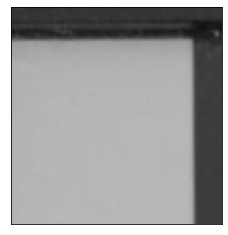

vacio


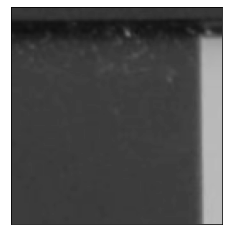

vacio


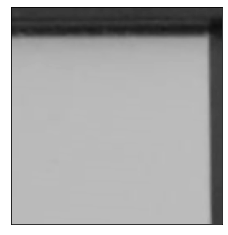

vacio


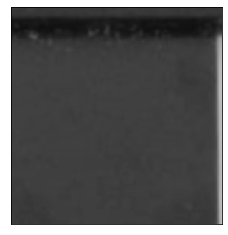

vacio


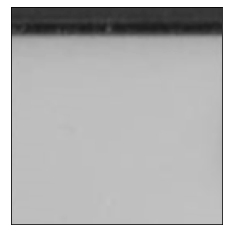

Torre negra


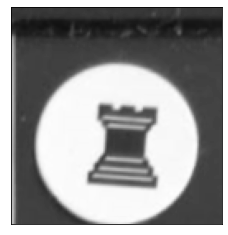

Rey negro


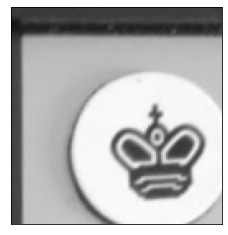

vacio


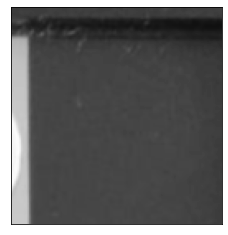

vacio


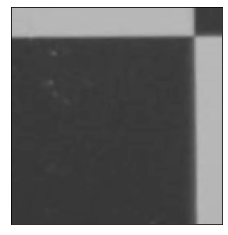

vacio


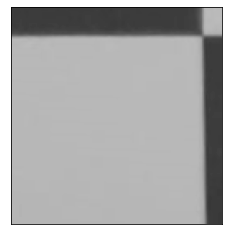

vacio


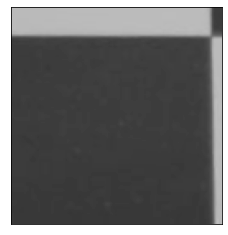

vacio


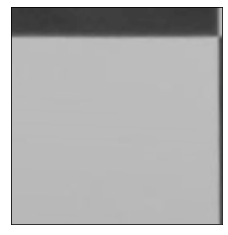

vacio


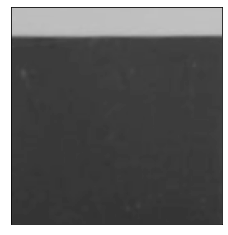

vacio


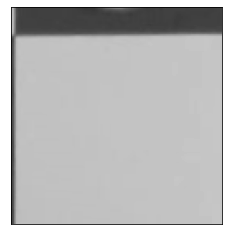

vacio


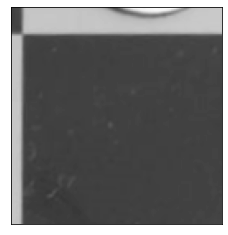

Alfil blanco


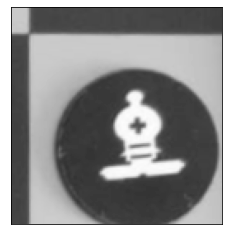

Caballo blanco


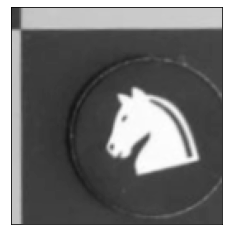

Alfil blanco


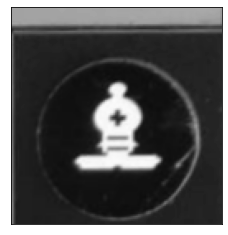

vacio


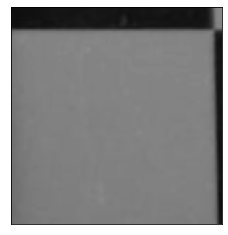

vacio


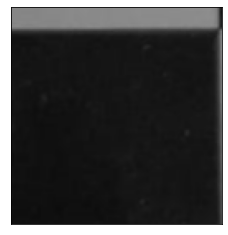

vacio


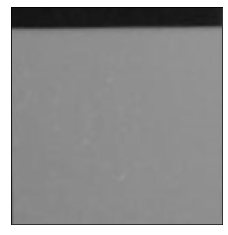

vacio


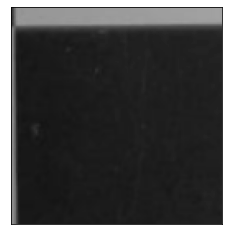

vacio


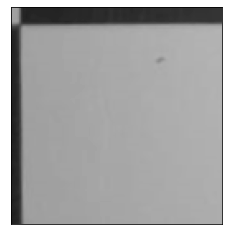

vacio


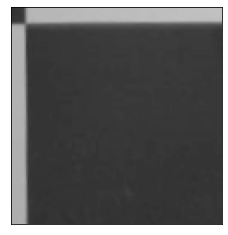

vacio


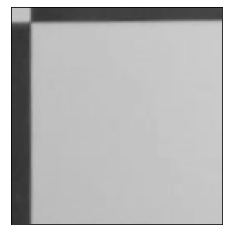

vacio


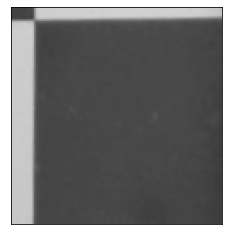

vacio


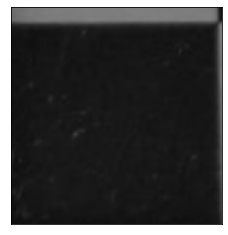

vacio


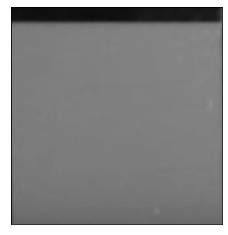

vacio


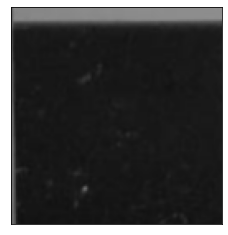

vacio


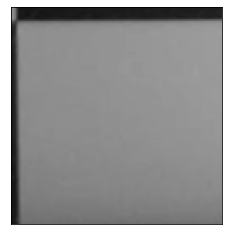

vacio


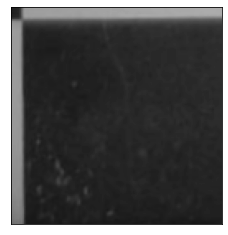

vacio


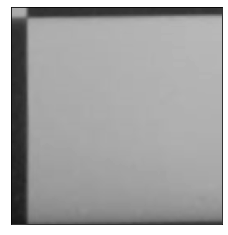

Rey blanco


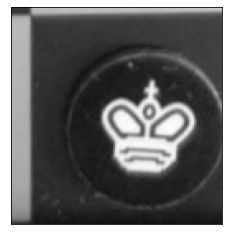

vacio


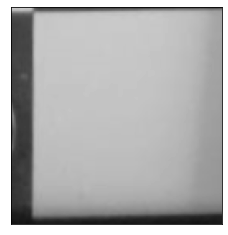

Porcentaje de acierto:  46.875   30 /64


In [45]:
#Descomentar sol correspondiente a ejemplo

sol = tablero_inicial
#sol = tablero_jaque_mate

matriz_aciertos = (tableroAProbar == sol)
print("Matriz de aciertos:")
print(matriz_aciertos)
print("\n")
lista_fallos = []
for i in range(8):
    for j in range(8):
        if not matriz_aciertos[i,j]:
            lista_fallos.append((i,j))

ds = getDescriptors()
for i,j in lista_fallos:
    
    print(clase[identificaFigura(cas[i][j], ds)])
    muestra(cas[i][j])
    
f = len(lista_fallos)
print("Porcentaje de acierto: ",((64-f)/64)*100, " ", 64-f,"/64")